In [8]:
import glob
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plot
import itertools
from datetime import datetime

# Also needed:
# ipykernel (for running Jupyter Notebooks)
# openpyxl (to open Excel (.xlsx) files)

# Missing value check
def miss_check(list):
    if not list:
        list_idx = None
    else:
        list_idx = list[0]
    return list_idx

In [2]:
# Loading data

poc_files = glob.glob("temp_data/*.xlsx") # glob is used to generate a list of files matching an expression in a folder
poc_df = [pd.read_excel(file, sheet_name='Data') for file in poc_files] # we then loop through the list made (poc_files) reading each file
poc_data = pd.concat(poc_df) # then we compress this into a single dataframe (assuming consistent headers)

msc_poc_data = poc_data[poc_data['SampleType']=='MSC'] # extract just data labelled as 'MSC', marine snow catcher

### Main
Processing is done following the calculations presented in Giering et al 2023 $^{1}$. Changes are made to the equation for calculating P $_{fast}$, the result is divided by 1000, see
$$
P_{fast} = \frac{(P_{tray} - P_{base})\ ✕\ V_{tray} / (A_{tray}\ ✕\ h_{MSC})}{1000}
$$

to translate units to $\mu{g}\ L^{-1}$ rather than $\mu{g}\ m^{-1}$.

[1]: https://doi.org/10.1016/j.dsr2.2023.105277. S.L.C. Giering, R. Sanders, S. Blackbird, N. Briggs, F. Carvalho, H. East, B. Espinola, S.A. Henson, K. Kiriakoulakis, M.H. Iversen, R.S. Lampitt, K. Pabortsava, C. Pebody, K. Peel, C. Preece, K. Saw, M. Villa-Alfageme, G.A. Wolff,
Vertical imbalance in organic carbon budgets is indicative of a missing vertical transfer during a phytoplankton bloom near South Georgia (COMICS),
Deep Sea Research Part II: Topical Studies in Oceanography

In [3]:

# Volume of MSC tray (fixed for time being).
xx_vol_of_tray = 1

# General info
MSC_number        = []
MSC_station       = []
MSC_event_number  = []
MSC_Fraction      = []
MSC_POC_mean      = []
MSC_POC_std_err   = []
MSC_nominal_depth = []
MSC_misfire       = []

# Particle fraction OC content
MSC_P_sus        = []
MSC_P_sus_err    = []

MSC_P_slow       = []
MSC_P_slow_err   = []

MSC_P_fast       = []
MSC_P_fast_err   = []

# Flux
MSC_F_slow       = []
MSC_F_slow_err   = []

MSC_F_fast_lower     = []
MSC_F_fast_lower_err = []
MSC_F_fast_upper     = []
MSC_F_fast_upper_err = []

MSC_F_total_lower     = []
MSC_F_total_lower_err = []
MSC_F_total_upper     = []
MSC_F_total_upper_err = []

# Main processing loop

for xx_MSC_number in pd.unique(msc_poc_data['CTD_UW_MSC_number']): # Work through each MSC.

    xx_cur_MSC_df = msc_poc_data[msc_poc_data['CTD_UW_MSC_number']==xx_MSC_number] # Separate dataframe for each MSC.

    # Initialise a bunch of blank lists to fill.
    # Fraction key.
    cur_frac = []

    # MSC fraction POC content.
    xx_cur_MSC_T0   = []
    xx_cur_MSC_Top  = []
    xx_cur_MSC_Base = []
    xx_cur_MSC_Tray = []

    xx_cur_MSC_T0_err   = []
    xx_cur_MSC_Top_err  = []
    xx_cur_MSC_Base_err = []
    xx_cur_MSC_Tray_err = []

    # Particle fraction OC content.
    xx_cur_MSC_P_sus  = []
    xx_cur_MSC_P_slow = []
    xx_cur_MSC_P_fast = []

    xx_cur_MSC_P_sus_err  = []
    xx_cur_MSC_P_slow_err = []
    xx_cur_MSC_P_fast_err = []

    # Flux from each fraction.
    xx_cur_MSC_F_slow       = []
    xx_cur_MSC_F_fast_lower = []
    xx_cur_MSC_F_fast_upper = []

    xx_cur_MSC_F_slow_err       = []
    xx_cur_MSC_F_fast_lower_err = []
    xx_cur_MSC_F_fast_upper_err = []

    for xx_cur_frac in xx_cur_MSC_df['SampleSubtype']: # Loop through each MSC fraction.

        if xx_cur_frac in cur_frac: # If duplicated, skip, as above will catch both.

            continue

        else:

            cur_frac.append(xx_cur_frac)

            xx_cur_frac_df = xx_cur_MSC_df[xx_cur_MSC_df['SampleSubtype']==xx_cur_frac]

            # General information

            xx_cur_frac_POC = np.mean(xx_cur_frac_df['POC_ug_L'])

            xx_cur_frac_POC_std = xx_cur_frac_df['POC_ug_L_stdev']

            xx_cur_frac_nom_dep = xx_cur_frac_df['NominalDepth_m']
            xx_cur_frac_nom_dep = xx_cur_frac_nom_dep.tolist()

            xx_cur_frac_mis = xx_cur_frac_df['Misfire']
            xx_cur_frac_mis = xx_cur_frac_mis.tolist()

            xx_MSC_station = xx_cur_frac_df['Station']
            xx_MSC_station = xx_MSC_station.tolist()

            xx_MSC_ev_num = xx_cur_frac_df['EventNumber']
            xx_MSC_ev_num = xx_MSC_ev_num.tolist()

            ### Error propogation - This can/should be turned into a function
            xx_sum = np.sum(np.square(xx_cur_frac_POC_std))
            n = len(xx_cur_frac_POC_std)
            xx_cur_frac_POC_std_err = math.sqrt(xx_sum / (n**2)) if n else np.nan
            ###
    
            if xx_cur_frac == 'Tzero':

                xx_cur_MSC_T0     = xx_cur_frac_POC
                xx_cur_MSC_T0_err = xx_cur_frac_POC_std_err

            elif xx_cur_frac == 'Top':

                xx_cur_MSC_Top     = xx_cur_frac_POC
                xx_cur_MSC_Top_err = xx_cur_frac_POC_std_err

            elif xx_cur_frac == 'Base':

                xx_cur_MSC_Base     = xx_cur_frac_POC
                xx_cur_MSC_Base_err = xx_cur_frac_POC_std_err

            elif xx_cur_frac == 'Tray':

                xx_cur_MSC_Tray     = xx_cur_frac_POC
                xx_cur_MSC_Tray_err = xx_cur_frac_POC_std_err

        MSC_number.append(xx_MSC_number)
        MSC_Fraction.append(xx_cur_frac)
        MSC_POC_mean.append(xx_cur_frac_POC)
        MSC_POC_std_err.append(xx_cur_frac_POC_std_err)

        xx_MSC_station = miss_check(xx_MSC_station)
        MSC_station.append(xx_MSC_station)

        xx_MSC_ev_num = miss_check(xx_MSC_ev_num)
        MSC_event_number.append(xx_MSC_ev_num)

        xx_cur_frac_nom_dep = miss_check(xx_cur_frac_nom_dep)
        MSC_nominal_depth.append(xx_cur_frac_nom_dep)

        xx_cur_frac_mis = miss_check(xx_cur_frac_mis)
        MSC_misfire.append(xx_cur_frac_mis)

        ## Particle fraction content ##

        ### 'Calculting' P_sus (assinging the Top fraction to P_sus!)
        if not xx_cur_MSC_Top:
            xx_cur_MSC_P_sus = None
            MSC_P_sus.append(xx_cur_MSC_P_sus)
        else:
            xx_cur_MSC_P_sus = xx_cur_MSC_Top
            MSC_P_sus.append(xx_cur_MSC_P_sus)

        #### 'Calculting' P_sus error
        if [x for x in (xx_cur_MSC_Top, xx_cur_MSC_Top_err) if not x]:
            xx_cur_MSC_P_sus_err = None
            MSC_P_sus_err.append(xx_cur_MSC_P_sus_err)
        else:
            xx_cur_MSC_P_sus_err = xx_cur_MSC_Top_err
            MSC_P_sus_err.append(xx_cur_MSC_P_sus_err)

        ### Calculting P_slow
        if [x for x in (xx_cur_MSC_Top, xx_cur_MSC_Base) if not x]:
            xx_cur_MSC_P_slow = None
            MSC_P_slow.append(xx_cur_MSC_P_slow)
        else:
            xx_cur_MSC_P_slow = ( (xx_cur_MSC_Base - xx_cur_MSC_Top) * 8/95 )
            MSC_P_slow.append(xx_cur_MSC_P_slow)

        #### Calculting P_slow error
        if [x for x in (xx_cur_MSC_Top, xx_cur_MSC_Base, xx_cur_MSC_Top_err, xx_cur_MSC_Base_err) if not x]:
            xx_cur_MSC_P_slow_err = None
            MSC_P_slow_err.append(xx_cur_MSC_P_slow_err)
        else:
            xx_cur_MSC_P_slow_err = ( (xx_cur_MSC_Base_err - xx_cur_MSC_Top_err) * 8/95 )
            MSC_P_slow_err.append(xx_cur_MSC_P_slow_err)

        ### Calculating P_fast
        if [x for x in (xx_cur_MSC_Tray, xx_cur_MSC_Base) if not x]:
            xx_cur_MSC_P_fast = None
            MSC_P_fast.append(xx_cur_MSC_P_fast)
        else:
            xx_cur_MSC_P_fast = ( ( (xx_cur_MSC_Tray - xx_cur_MSC_Base) * ( xx_vol_of_tray/(0.026/1.58) ) )/1000 )
            MSC_P_fast.append(xx_cur_MSC_P_fast)

        #### Calculting P_fast error
        if [x for x in (xx_cur_MSC_Tray, xx_cur_MSC_Base, xx_cur_MSC_Tray_err, xx_cur_MSC_Base_err) if not x]:
            xx_cur_MSC_P_fast_err = None
            MSC_P_fast_err.append(xx_cur_MSC_P_fast_err)
        else:
            xx_cur_MSC_P_fast_err = ( ( (xx_cur_MSC_Tray_err - xx_cur_MSC_Base_err) * ( xx_vol_of_tray/(0.026/1.58) ) )/1000 )
            MSC_P_fast_err.append(xx_cur_MSC_P_fast_err)

        ## Calculating flux ##

        ### Calculating F_slow
        if not xx_cur_MSC_P_slow:
            xx_cur_MSC_F_slow = None
            MSC_F_slow.append(xx_cur_MSC_F_slow)
        else:
            xx_cur_MSC_F_slow = ( ( xx_cur_MSC_P_slow * 95 ) / (0.06 * (2/24)) )
            MSC_F_slow.append(xx_cur_MSC_F_slow)

        #### Calculating F_slow error
        if not xx_cur_MSC_P_slow_err:
            xx_cur_MSC_F_slow_err = None
            MSC_F_slow_err.append(xx_cur_MSC_F_slow_err)
        else:
            xx_cur_MSC_F_slow_err = ( ( xx_cur_MSC_P_slow_err * 95 ) / (0.06 * (2/24)) )
            MSC_F_slow_err.append(xx_cur_MSC_F_slow_err)

        ### Calculating F_fast ###

            #### F_fast_lower
        if not xx_cur_MSC_P_fast:
            xx_cur_MSC_F_fast_lower = None
            MSC_F_fast_lower.append(xx_cur_MSC_F_fast_lower)
        else:
            xx_cur_MSC_F_fast_lower = ( ( xx_cur_MSC_P_fast * 95 ) / (0.06 * (2/24)) )
            MSC_F_fast_lower.append(xx_cur_MSC_F_fast_lower)

            #### F_fast_lower_error
        if not xx_cur_MSC_P_fast_err:
            xx_cur_MSC_F_fast_lower_err = None
            MSC_F_fast_lower_err.append(xx_cur_MSC_F_fast_lower_err)
        else:
            xx_cur_MSC_F_fast_lower_err = ( ( xx_cur_MSC_P_fast_err * 95 ) / (0.06 * (2/24)) )
            MSC_F_fast_lower_err.append(xx_cur_MSC_F_fast_lower_err)
            
            #### F_fast_upper
        if not xx_cur_MSC_P_fast:
            xx_cur_MSC_F_fast_upper = None
            MSC_F_fast_upper.append(xx_cur_MSC_F_fast_upper)
        else:
            xx_cur_MSC_F_fast_upper = ( xx_cur_MSC_P_fast * 40 * 1000) # Multiplying by 1000 to go to µg/L
            MSC_F_fast_upper.append(xx_cur_MSC_F_fast_upper)

            #### F_fast_upper_error
        if not xx_cur_MSC_P_fast_err:
            xx_cur_MSC_F_fast_upper_err = None
            MSC_F_fast_upper_err.append(xx_cur_MSC_F_fast_upper_err)
        else:
            xx_cur_MSC_F_fast_upper_err = ( xx_cur_MSC_P_fast_err * 40 * 1000) # Multiplying by 1000 to go to µg/L
            MSC_F_fast_upper_err.append(xx_cur_MSC_F_fast_upper_err)

        ### Total flux ###

        #### Lower total flux
        if [x for x in (xx_cur_MSC_F_slow, xx_cur_MSC_F_fast_lower, xx_cur_MSC_F_fast_upper) if not x]:
            xx_cur_MSC_F_total_lower = None
            MSC_F_total_lower.append(xx_cur_MSC_F_total_lower)
        else:
            xx_cur_MSC_F_total_lower = xx_cur_MSC_F_slow + xx_cur_MSC_F_fast_lower
            MSC_F_total_lower.append(xx_cur_MSC_F_total_lower)

        #### Lower total flux error
        if [x for x in (xx_cur_MSC_F_slow_err, xx_cur_MSC_F_fast_lower_err, xx_cur_MSC_F_fast_upper_err) if not x]:
            xx_cur_MSC_F_total_lower_err = None
            MSC_F_total_lower_err.append(xx_cur_MSC_F_total_lower_err)
        else:
            xx_cur_MSC_F_total_lower_err = math.sqrt(xx_cur_MSC_F_slow_err**2 + xx_cur_MSC_F_fast_lower_err**2)
            MSC_F_total_lower_err.append(xx_cur_MSC_F_total_lower_err)

        #### Upper total flux
        if [x for x in (xx_cur_MSC_F_slow, xx_cur_MSC_F_fast_lower, xx_cur_MSC_F_fast_upper) if not x]:
            xx_cur_MSC_F_total_upper = None
            MSC_F_total_upper.append(xx_cur_MSC_F_total_upper)
        else:
            xx_cur_MSC_F_total_upper = xx_cur_MSC_F_slow + xx_cur_MSC_F_fast_upper
            MSC_F_total_upper.append(xx_cur_MSC_F_total_upper)

        #### Upper total flux error
        if [x for x in (xx_cur_MSC_F_slow_err, xx_cur_MSC_F_fast_lower_err, xx_cur_MSC_F_fast_upper_err) if not x]:
            xx_cur_MSC_F_total_upper_err = None
            MSC_F_total_upper_err.append(xx_cur_MSC_F_total_upper_err)
        else:
            xx_cur_MSC_F_total_upper_err = math.sqrt(xx_cur_MSC_F_slow_err**2 + xx_cur_MSC_F_fast_upper_err**2)
            MSC_F_total_upper_err.append(xx_cur_MSC_F_total_upper_err)



# Build into single dataframe

xx_all_data = {'MSC_Number'           : MSC_number,
               'MSC_Station'          : MSC_station,
               'MSC_Event_Number'     : MSC_event_number,
               'MSC_Fraction'         : MSC_Fraction, 
               'MSC_Nominal_Depth'    : MSC_nominal_depth,
               'MSC_Misfire'          : MSC_misfire,
               'MSC_POC_mean'         : MSC_POC_mean, 
               'MSC_POC_std_err'      : MSC_POC_std_err,
               'MSC_P_sus'            : MSC_P_sus,
               'MSC_P_sus_err'        : MSC_P_sus_err,
               'MSC_P_slow'           : MSC_P_slow,
               'MSC_P_slow_err'       : MSC_P_slow_err,
               'MSC_P_fast'           : MSC_P_fast,
               'MSC_P_fast_err'       : MSC_P_fast_err,
               'MSC_F_slow'           : MSC_F_slow,
               'MSC_F_slow_err'       : MSC_F_slow_err,
               'MSC_F_fast_lower'     : MSC_F_fast_lower,
               'MSC_F_fast_lower_err' : MSC_F_fast_lower_err,
               'MSC_F_fast_upper'     : MSC_F_fast_upper,
               'MSC_F_fast_upper_err' : MSC_F_fast_upper_err,
               'MSC_F_total_lower'    : MSC_F_total_lower,
               'MSC_F_total_lower_err': MSC_F_total_lower_err,
               'MSC_F_total_upper'    : MSC_F_total_upper,
               'MSC_F_total_upper_err': MSC_F_total_upper_err
               }

MSC_POC = pd.DataFrame(xx_all_data)


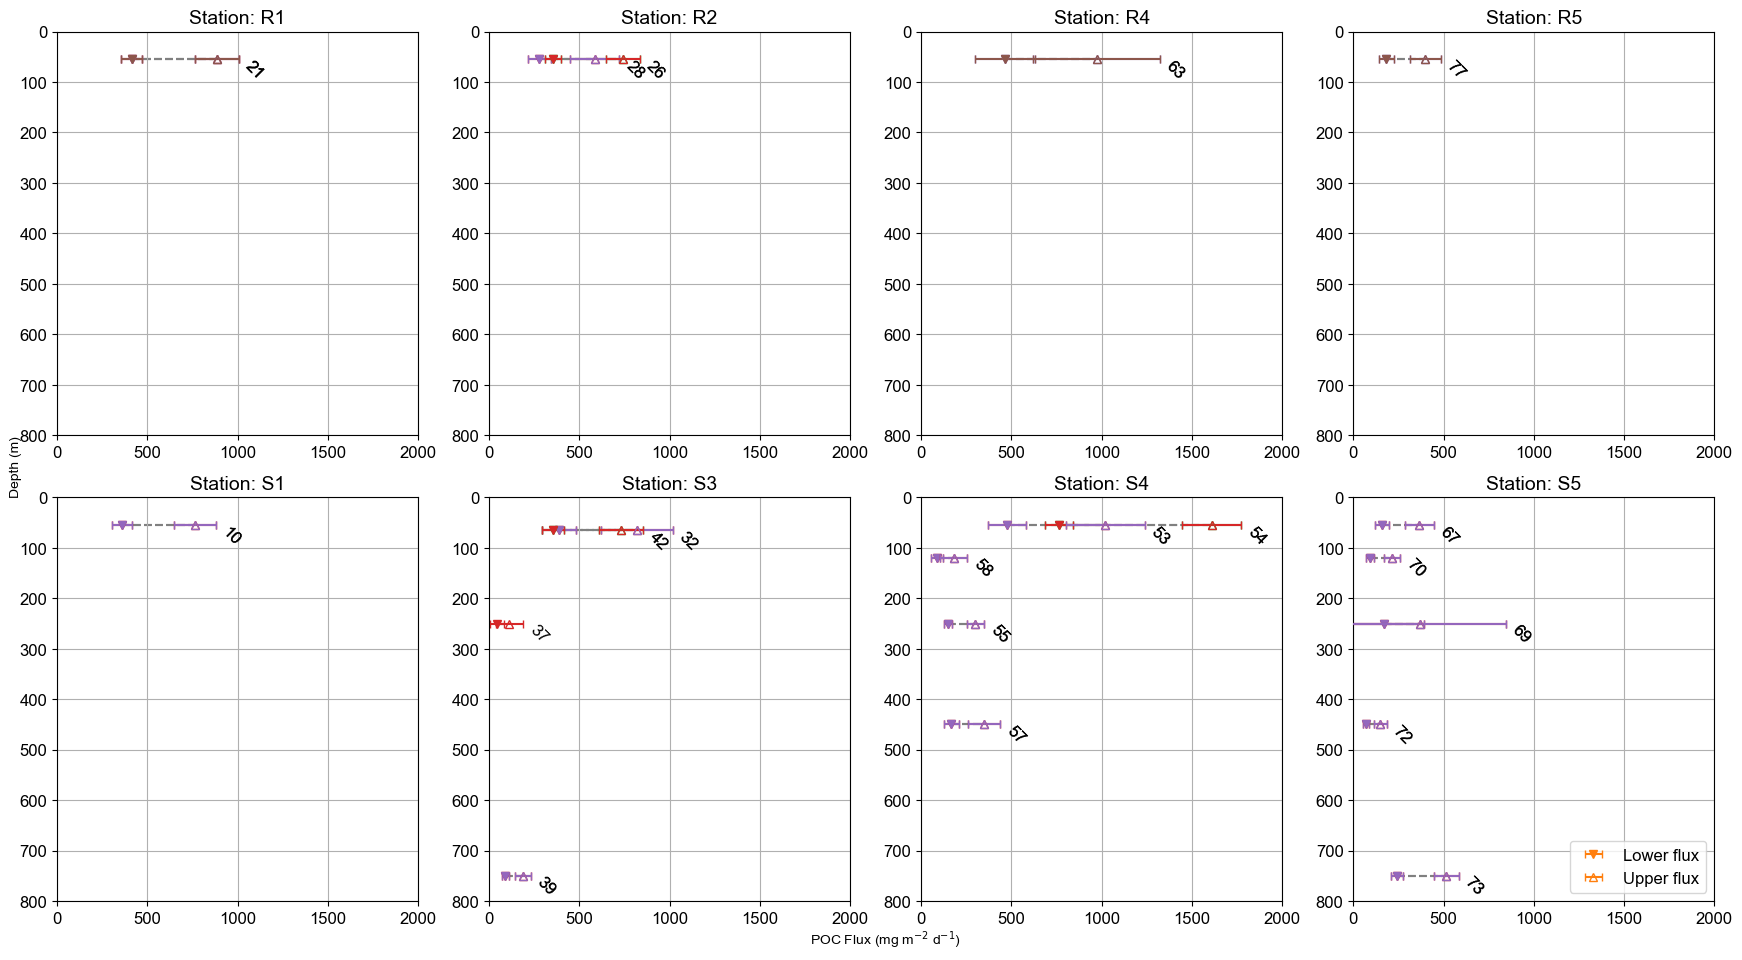

In [4]:
# Plotting
plot.rcParams["font.family"] = "Arial"

# Filter stations upfront
valid_stations = []
for station in MSC_POC['MSC_Station'].dropna().unique():
    df_station = MSC_POC[
        (MSC_POC['MSC_Station'] == station) &
        (MSC_POC['MSC_Misfire'] == 'No')
    ]
    if not (
        df_station['MSC_F_total_lower'].isna().all() or
        df_station['MSC_F_total_upper'].isna().all()
    ):
        valid_stations.append(station)

# Split into R and S stations
r_stations = sorted([s for s in valid_stations if str(s).startswith('R')])
s_stations = sorted([s for s in valid_stations if str(s).startswith('S')])
station_groups = [r_stations, s_stations]

# Determine number of columns (max of the two groups)
ncols = max(len(r_stations), len(s_stations))
fig, axes = plot.subplots(2, ncols, figsize=(4.5 * ncols, 10))
axes = axes.reshape(2, ncols)

# Add shared axis labels
fig.add_subplot(111, frameon=False)
plot.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plot.grid(False)
plot.xlabel('POC Flux (mg m$^{-2}$ d$^{-1}$)')
plot.ylabel("Depth (m)")

# Define color pairs
default_colors = ('#1f77b4', '#1f77b4')
color_pairs = [
    ('#ff7f0e', '#ff7f0e'),
    ('#2ca02c', '#2ca02c'),
    ('#d62728', '#d62728'),
    ('#9467bd', '#9467bd'),
    ('#8c564b', '#8c564b'),
]

# Updated plotting loop with labels (only added once)
for row_idx, station_list in enumerate(station_groups):
    for col_idx, station in enumerate(station_list):
        ax = axes[row_idx, col_idx]
        df_station = MSC_POC[
            (MSC_POC['MSC_Station'] == station) &
            (MSC_POC['MSC_Misfire'] == 'No')
        ]

        seen_labels = set()  # track if labels have been used

        for depth, group in df_station.groupby('MSC_Nominal_Depth'):
            if len(group) == 1:
                row = group.iloc[0]
                lower = row['MSC_F_total_lower'] / 1000
                lower_err = row['MSC_F_total_lower_err'] / 1000
                upper = row['MSC_F_total_upper'] / 1000
                upper_err = row['MSC_F_total_upper_err'] / 1000
                msc_num = row['MSC_Number']

                ax.plot([lower, upper], [depth, depth], linestyle='--', color='gray', zorder=1)
                ax.errorbar(lower, depth, xerr=lower_err, fmt='v',
                            color=default_colors[0], capsize=3, zorder=2,
                            label='Lower flux' if 'lower' not in seen_labels else "")
                seen_labels.add('lower')
                ax.errorbar(upper, depth, xerr=upper_err, fmt='^',
                            mfc='none', mec=default_colors[1], ecolor=default_colors[1], capsize=3, zorder=3,
                            label='Upper flux' if 'upper' not in seen_labels else "")
                seen_labels.add('upper')

                cap_x = upper + upper_err

                if pd.notna(msc_num):
                    ax.text(cap_x + 20, depth + 20, str(int(msc_num)) if pd.notna(msc_num) else '', va='center', fontsize=12, color='black', rotation=-45)

            else:
                color_cycle = itertools.cycle(color_pairs)
                for _, row in group.iterrows():
                    lower = row['MSC_F_total_lower'] / 1000
                    lower_err = row['MSC_F_total_lower_err'] / 1000
                    upper = row['MSC_F_total_upper'] / 1000
                    upper_err = row['MSC_F_total_upper_err'] / 1000
                    msc_num = row['MSC_Number']
                    lower_col, upper_col = next(color_cycle)

                    ax.plot([lower, upper], [depth, depth], linestyle='--', color='gray', zorder=1)
                    ax.errorbar(lower, depth, xerr=lower_err, fmt='v',
                                color=lower_col, capsize=3, zorder=2,
                                label='Lower flux' if 'lower' not in seen_labels else "")
                    seen_labels.add('lower')
                    ax.errorbar(upper, depth, xerr=upper_err, fmt='^',
                                mfc='none', mec=upper_col, ecolor=upper_col, capsize=3, zorder=3,
                                label='Upper flux' if 'upper' not in seen_labels else "")
                    seen_labels.add('upper')

                    cap_x = upper + upper_err

                    if pd.notna(msc_num):
                        ax.text(cap_x + 20, depth + 20, str(int(msc_num)) if pd.notna(msc_num) else '', va='center', fontsize=12, color='black', rotation=-45)

        ax.set_xlim(0, 2000)
        ax.set_ylim(0, 800)
        ax.set_title(f'Station: {station}', fontsize=14)
        ax.invert_yaxis()
        ax.grid(True)
        ax.tick_params(labelsize=12)

    # Hide unused axes in this row
    for empty_ax in axes[row_idx, len(station_list):]:
        empty_ax.set_visible(False)

# 🔍 Put legend in the bottom-right *visible* subplot
visible_axes = [ax for ax_row in axes for ax in ax_row if ax.get_visible()]
if visible_axes:
    bottom_right_ax = visible_axes[-1]
    handles, labels = visible_axes[0].get_legend_handles_labels()
    if handles:
        unique = dict(zip(labels, handles))
        bottom_right_ax.legend(unique.values(), unique.keys(), loc='lower right', fontsize=12)

plot.tight_layout()
plot.show()


In [7]:
# Export DataFrame as CSV

xx_cur_date = datetime.today().strftime('%Y%m%d')

MSC_POC.to_csv(f'xx_cur_date_Hans_MSC_Flux_Data.csv')
MSC_POC.to_excel(fxx_cur_date +'_20250513_Hans_MSC_Flux_Data.xlsx'})